In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skl2onnx import to_onnx
from onnxruntime import InferenceSession
%matplotlib inline

In [2]:
# Load the data
data_path = "filled_data.csv"
data = pd.read_csv(data_path)

# Extract the relevant columns
datetime_column = pd.to_datetime(data['datetime'])
# Get all feature columns except 'datetime'
feature_columns = data.columns[1:]  # Exclude the 'datetime' column
from challenge_utils import build_training_data

In [4]:
data.shape

(17520, 28)

In [7]:
data.head()

,datetime,AirTemp,pres,rain,rh,wd,ws,Global_Solar_Flux,Diffuse_Solar_Flux,Direct_Solar_Flux,...,kw_heatingcoolingtotal_zone1,kw_heatingcoolingtotal_zone2,kw_lights_zone1,kw_lights_zone2,kw_total_zone1,kw_total_zone2,kw_ventilation_zone1,kw_ventilation_zone2,kw_water_heater_zone2,plugs_zone2
0,2022-01-01 00:00:00+00:00,10.279,1005.058,0.000,95.870,187.576,1.758,-0.271,-0.370,-0.110,...,-1.798,-2.037,-0.002,-0.222,2.091,2.308,-0.027,-0.030,-0.004,-0.156
1,2022-01-01 01:00:00+00:00,10.318,1004.790,0.000,95.335,218.280,2.401,-0.371,-0.499,-0.231,...,-1.794,-2.170,-0.002,-0.278,2.086,2.504,-0.027,-0.044,-0.004,-0.157
2,2022-01-01 02:00:00+00:00,9.901,1004.791,0.013,95.699,185.351,1.821,-0.846,-0.999,-0.235,...,-1.795,-2.202,-0.002,-0.238,2.085,2.501,-0.026,-0.043,-0.004,-0.157
3,2022-01-01 03:00:00+00:00,9.444,1004.554,0.000,95.881,193.537,1.760,-0.632,-0.755,-0.173,...,-1.811,-2.238,-0.002,-0.240,2.100,2.539,-0.026,-0.044,-0.004,-0.157
4,2022-01-01 04:00:00+00:00,8.587,1004.524,0.000,96.738,174.806,1.613,-0.395,-0.489,-0.110,...,-1.814,-2.287,-0.002,-0.280,2.102,2.952,-0.027,-0.044,-0.356,-0.156


In [21]:
cov_matrix = data.cov()
cov_matrix.loc["kw_total_zone2"]

AirTemp                          -6.440517
pres                              1.156721
rain                             -0.000149
rh                                5.829063
wd                               -3.434167
ws                                0.295349
Global_Solar_Flux                 5.404324
Diffuse_Solar_Flux               10.387751
Direct_Solar_Flux                 7.674720
Downwelling_IR_Flux             -22.614136
SAA                             -22.305552
SZA                              -1.722909
PAC                             285.544537
TGBT [kW]                        25.069276
kw_heater_corridor1_zone1        -0.409996
kw_heaters_corridor_zone2        -0.706029
kw_heaters_toilets_zone2         -0.190324
kw_heatingcoolingtotal_zone1     -3.348341
kw_heatingcoolingtotal_zone2     -2.434328
kw_lights_zone1                  -0.455660
kw_lights_zone2                  -0.350215
kw_total_zone1                    4.773479
kw_total_zone2                    3.272113
kw_ventilat

In [12]:
target_time, target, predictors = build_training_data('filled_data.csv')
print(target.shape)
print(predictors.shape)

Loaded hourly data
Calculated daily energy consumption
Calculated predictor window
(723,)
(723, 168, 27)


In [9]:
predictors.shape
data.columns[23]

'kw_total_zone2'

In [10]:
# Exclude the first column (datetime)
input_data = data.iloc[:, 1:]

# Calculate the number of days (excluding the first week)
num_days = 730 - 7  # 730 days with the first 7 days skipped

# Initialize the 3D array: 24 hour, 27 variable
targets = np.zeros((num_days, 24, input_data.shape[1]))

# Iterate through each day and extract the data
for day in range(num_days):
    start_index = day * 24 + 7 * 24
    end_index = start_index + 24
    targets[day, :, :] = input_data.iloc[start_index:end_index, :]

targets = targets[:, :, 22] # taking the kw_zone 2 to predict



In [13]:
targets.shape

(723, 24)

In [8]:
from sklearn.preprocessing import MinMaxScaler

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape the array to (723 * 168, 27) to apply MinMaxScaler
reshaped_predictors = predictors.reshape(-1, 27)

# Fit and transform the data
scaled_predictors = scaler.fit_transform(reshaped_predictors)

# Reshape the scaled data back to the original shape
predictors = scaled_predictors.reshape(predictors.shape)


reshaped_target = target.reshape(-1, 1)
targets = scaler.fit_transform(targets)
# target = scaler.fit_transform(reshaped_target)

print(predictors.shape)
print(targets.shape)


(723, 168, 27)
(723, 24)


In [10]:
from sklearn.model_selection import train_test_split

# split_index = int(len(targets) * 0.8)

# # Split the vectors into training and testing sets
# train_y, test_y = target[:split_index], target[split_index:]
# train_X, test_X = predictors[:split_index], predictors[split_index:]

train_X, test_X, train_y, test_y, indices_train, indices_test = train_test_split(predictors, targets, np.arange(len(targets)), test_size=0.2, random_state=55)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(578, 168, 27) (578, 24) (145, 168, 27) (145, 24)


In [11]:
len(indices_test)

145

In [12]:
def relative_squared_error(y_pred, y_true):
    """Relative squared error (RSE; also called relative mean square error). < 1 is good, = 1 is bad, > 1 really bad."""
    return K.mean((y_pred - y_true)**2)/K.mean((y_true - K.mean(y_true))**2)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [17]:
[x.shape for x in [train_X, train_y, test_X, test_y]]

NameError: name 'train_X' is not defined

In [15]:
m = Sequential()
m.add(LSTM(1, input_shape=(train_X.shape[1], train_X.shape[2])))
model.compile(loss='mse', optimizer='adam')

m(train_X[:1,:,:])

NameError: name 'Sequential' is not defined

In [15]:


# Design Lambda
int_layer = Lambda(lambda x: K.sum(x, axis=1))

# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(64))
model.add(Dense(24))
# model.add(Dense(1))
# model.add(int_layer)
model.compile(loss='mse', optimizer='adam')
# fit network


history = model.fit(train_X, train_y, epochs=75, batch_size=18, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/75
33/33 - 5s - loss: 0.0372 - val_loss: 0.0216 - 5s/epoch - 166ms/step
Epoch 2/75
33/33 - 3s - loss: 0.0175 - val_loss: 0.0159 - 3s/epoch - 104ms/step
Epoch 3/75
33/33 - 4s - loss: 0.0156 - val_loss: 0.0155 - 4s/epoch - 109ms/step
Epoch 4/75
33/33 - 3s - loss: 0.0149 - val_loss: 0.0152 - 3s/epoch - 100ms/step
Epoch 5/75
33/33 - 3s - loss: 0.0143 - val_loss: 0.0148 - 3s/epoch - 103ms/step
Epoch 6/75
33/33 - 3s - loss: 0.0139 - val_loss: 0.0147 - 3s/epoch - 97ms/step
Epoch 7/75
33/33 - 3s - loss: 0.0136 - val_loss: 0.0146 - 3s/epoch - 95ms/step
Epoch 8/75
33/33 - 3s - loss: 0.0133 - val_loss: 0.0145 - 3s/epoch - 101ms/step
Epoch 9/75
33/33 - 3s - loss: 0.0130 - val_loss: 0.0144 - 3s/epoch - 97ms/step
Epoch 10/75
33/33 - 3s - loss: 0.0128 - val_loss: 0.0143 - 3s/epoch - 99ms/step
Epoch 11/75
33/33 - 4s - loss: 0.0126 - val_loss: 0.0143 - 4s/epoch - 114ms/step
Epoch 12/75
33/33 - 3s - loss: 0.0124 - val_loss: 0.0144 - 3s/epoch - 99ms/step
Epoch 13/75
33/33 - 3s - loss: 0.0122 - va

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               51200     
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 24)                1560      
                                                                 
Total params: 59,224
Trainable params: 59,224
Non-trainable params: 0
_________________________________________________________________


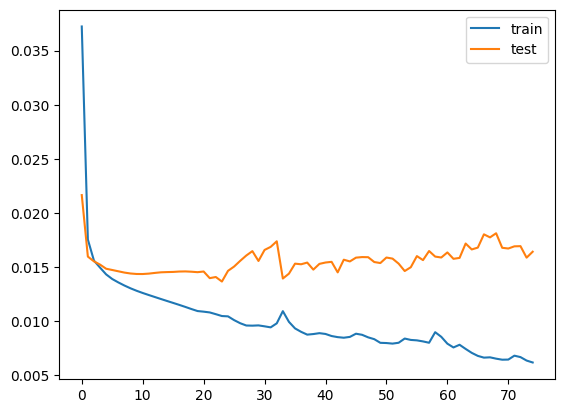

In [17]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
# make a prediction
yhat = model.predict(predictors)
yhat.shape

23/23 [==============================] - 1s 31ms/step


(723, 24)

In [19]:
yhat_test = model.predict(test_X)
yhat_test.shape

5/5 [==============================] - 0s 42ms/step


(145, 24)

In [20]:
yhat_train = model.predict(train_X)
yhat_train.shape

19/19 [==============================] - 1s 37ms/step


(578, 24)

In [21]:
train_target = target[indices_train]
train_target.shape

(578,)

In [22]:
test_target = target[indices_test]
test_target.shape

(145,)

In [23]:
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat.shape

(723, 24)

In [24]:
inv_yhat_train = scaler.inverse_transform(yhat_train)
inv_yhat_train.shape

(578, 24)

In [25]:
inv_yhat_test = scaler.inverse_transform(yhat_test)
inv_yhat_test.shape

(145, 24)

In [26]:
predicted_kw_zone2 = np.trapz(inv_yhat, axis=1)
predicted_kw_zone2.shape

(723,)

In [27]:
predicted_kw_zone2_train = np.trapz(inv_yhat_train, axis=1)
predicted_kw_zone2_train.shape

(578,)

In [28]:
predicted_kw_zone2_test = np.trapz(inv_yhat_test, axis=1)
predicted_kw_zone2_test.shape

(145,)

In [29]:
for i in range (len(predicted_kw_zone2)):
  print(predicted_kw_zone2[i], target[i])

56.399338 45.964000000000006
65.80018 57.75049999999999
111.79809 111.27949999999998
102.89123 96.05150000000002
99.73163 101.8965
101.181946 99.7285
87.64209 94.511
64.88383 57.508
102.623856 114.774
102.940765 93.792
94.146614 93.44750000000002
120.50233 112.281
119.8528 115.29699999999998
123.85371 118.81450000000002
85.84236 73.7635
104.47591 86.311
142.31752 136.92149999999998
159.93071 153.89149999999998
145.38918 133.4875
138.25061 135.09600000000003
118.23333 117.304
97.40328 84.843
89.68733 83.34049999999999
139.42377 131.41649999999998
120.82153 114.0025
89.62119 106.86600000000001
90.4845 111.908
126.39082 120.7865
88.60054 87.6235
85.70098 80.33050000000001
121.652504 128.498
118.54157 112.13699999999999
102.240234 103.40249999999999
73.70618 112.53550000000001
125.167816 42.04200000000001
53.21669 84.628
82.76061 83.50200000000001
127.87205 120.25899999999999
126.63109 123.74749999999999
94.40108 95.37050000000004
110.46536 99.69449999999999
102.91667 100.811
80.1589 85.27

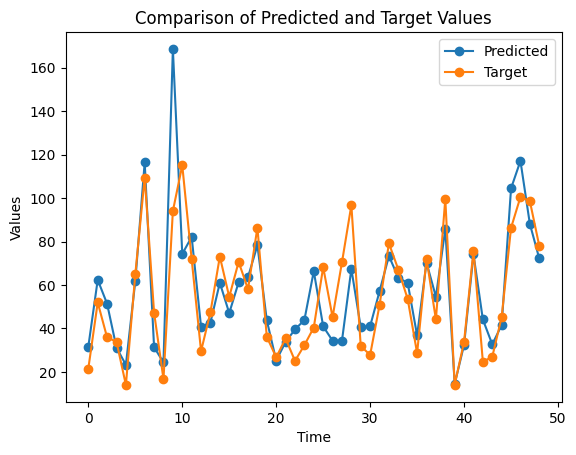

In [30]:
# Plotting
plt.plot(predicted_kw_zone2_test[::3], 'o-', label='Predicted')
plt.plot(test_target[::3], 'o-', label='Target')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Comparison of Predicted and Target Values')
plt.legend()
plt.show()

In [33]:
def relative_squared_error(y_pred, y_true):
    """Relative squared error (RSE; also called relative mean square error). < 1 is good, = 1 is bad, > 1 really bad."""
    return np.mean((y_pred - y_true)**2)/np.mean((y_true - y_true.mean())**2)

print(relative_squared_error(predicted_kw_zone2, target))

0.11864488107758704


In [48]:
# Calculate absolute difference or squared difference
absolute_diff = np.abs(predicted_kw_zone2 - target)
# Or squared_diff = (y_true - y_pred)**2

# Set a threshold 
threshold = 20  # Example threshold

# Find indices where the difference exceeds the threshold
far_away_indices = np.where(absolute_diff > threshold)[0]


far_away_in_test = np.intersect1d(far_away_indices, indices_test)
print(len(far_away_in_test))

63


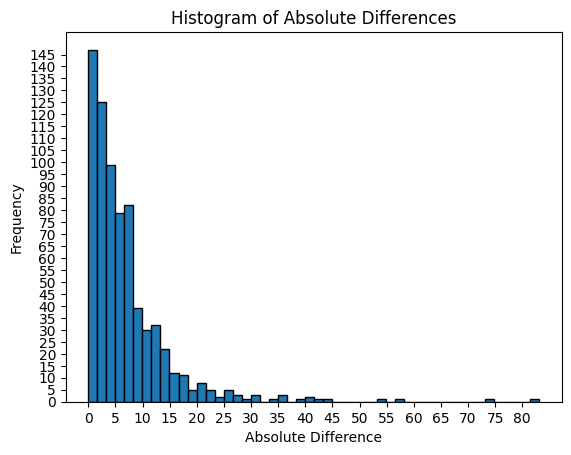

In [51]:
# Plot the histogram of absolute differences
plt.hist(absolute_diff, bins=50, edgecolor='black')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Absolute Differences')
plt.xticks(np.arange(0, max(absolute_diff), 5))
plt.yticks(np.arange(0, 150, 5))
plt.show()